In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
from HyperspectralAnalysis import HyperspectralAnalysis 
hyps = HyperspectralAnalysis()

In [3]:
# For Mg NPs, Feb 1
# path_int = '../Mg Analyses/250201/new_roi1_4.tdms'
# pathbc = '../Mg Analyses/250201/new_WC14.tdms'
# pathdc = '../Mg Analyses/250201/new_DC15.tdms'
# path_positions = '../Mg Analyses/250201/positions_newroi1.txt'
# wavei = 50 # index of starting wavelength 
# wavef = 670 # index of end wavelength

# path_int = '../Mg Analyses/250201/new_roi2_10.tdms'
# pathbc = '../Mg Analyses/250201/new_WC14.tdms'
# pathdc = '../Mg Analyses/250201/new_DC15.tdms'
# path_positions = '../Mg Analyses/250201/positions_newroi2.txt'
# wavei = 50 # index of starting wavelength 
# wavef = 670 # index of end wavelength

path_int = '../Mg Analyses/250202/roi1_c4_WC20.tdms'
pathbc = '../Mg Analyses/250201/new_WC14.tdms'
pathdc = '../Mg Analyses/250201/new_DC15.tdms'
path_positions = '../Mg Analyses/250202/positions_c4_20.txt'
wavei = 50 # index of starting wavelength 
wavef = 670 # index of end wavelength


In [4]:
pixel_params, wave_raw, inten_raw = hyps.read_tdms(tdms_file=TdmsFile.read(path_int), datalen=670)
_, w1, dc_raw =     hyps.read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=1340)
_, w2, bc_raw =    hyps.read_tdms(tdms_file=TdmsFile.read(pathbc),  datalen=1340)
positions = np.loadtxt(path_positions)
numPart = len(positions)


<IPython.core.display.Javascript object>


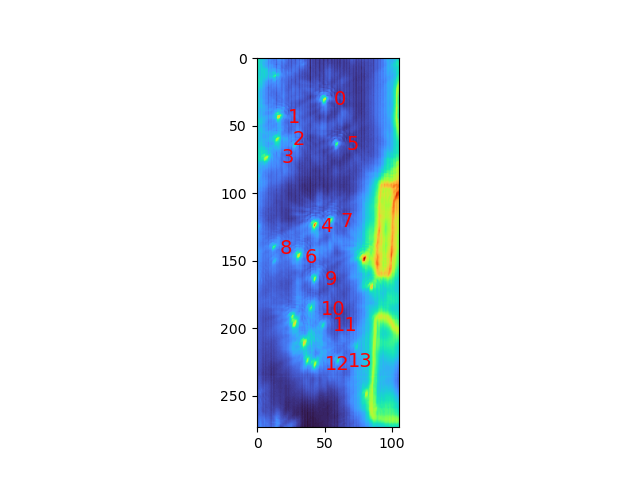

In [5]:
%matplotlib notebook
for i in range(numPart):
    plt.annotate(str(i), fontsize=14, xy=[int(positions[i][0]+5), int(positions[i][1]+5)],color='red')
plt.imshow(np.sum(inten_raw,2).T, cmap='turbo')


In [6]:
wc_minus_dc = hyps.process_wcdc(dc_raw=dc_raw, 
                         bc_raw=bc_raw,
                         pixel_params=pixel_params)

In [7]:
bk_global, indices = hyps.back_global(I_raw=inten_raw,
                                 percent=0.1)

DFS_backglob = hyps.calc_DFS(inten_raw=inten_raw, 
                             wc_minus_dc=wc_minus_dc, 
                             back=bk_global,
                             )

In [8]:
numWaves = wavef-wavei 


14 2 7


<IPython.core.display.Javascript object>


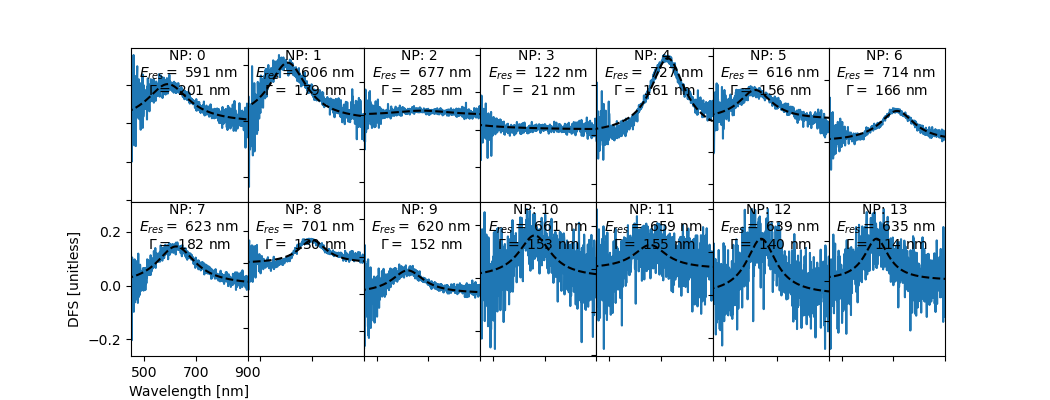

In [9]:
numrow = 2
numcol = int(np.ceil(numPart / numrow))

print(numPart, numrow, numcol)

fig, ax = plt.subplots(numrow, numcol, figsize=[numcol*1.5, numrow*2])

wave = wave_raw[wavei:wavef]
gam_tot = np.zeros(numPart)
eres_tot = np.zeros(numPart)

DFS_localgrid = hyps.calc_DFS_localgrid(specfin=inten_raw,
                    numPart=numPart,
                    positions=positions,
                    wavei=wavei,
                    wavef=wavef,
                    wc_minus_dc=wc_minus_dc,
                    offset=4)


for npi in range(0,numPart):
    rowi = npi // numcol
    coli = npi-numcol*rowi
    xi = int(positions[npi,0])-1
    yi = int(positions[npi,1])-1
    
    DFSi = DFS_localgrid[:, npi]
    fit, popt = hyps.fit_spectrum(wave, DFSi)

    ax[rowi,coli].plot(wave, DFSi)
    ax[rowi,coli].plot(wave, fit, color='k', linestyle='--')
    gam_tot[npi] = popt[1]; eres_tot[npi] = popt[2]
    titlename = 'NP: ' + str(npi) + ' \n' + str('$E_{res}=$ ')+str(int(np.round(popt[2])))+' nm \n' + str('$\Gamma=$ ')+str(int(np.round(popt[1])))+str(' nm')
    ax[rowi,coli].set_title(titlename, y=.64, fontsize=10)


    ax[rowi,coli].set_xlim([450,900]);
    ax[rowi,coli].set_xticks([500, 700, 900])
#     ax[rowi,coli].set_ylim([0,2]);

    if rowi < 1:
        ax[rowi,coli].set_xticklabels([])
        ax[rowi,coli].set_yticklabels([])
    if coli > 0:
        ax[rowi,coli].set_xticklabels([])
        ax[rowi,coli].set_yticklabels([])
        
# ax[1,5].set_yticklabels([])
# ax[3,5].set_yticklabels([])

ax[rowi, 0].set_xlabel('Wavelength [nm]')
ax[rowi,0].set_ylabel('DFS [unitless]')
fig.subplots_adjust(wspace=0, hspace=0)
# # fig.savefig('auNRs_subset_allspectra.png', dpi=600)

In [10]:
plt.rcParams['figure.facecolor'] = 'none'


<IPython.core.display.Javascript object>


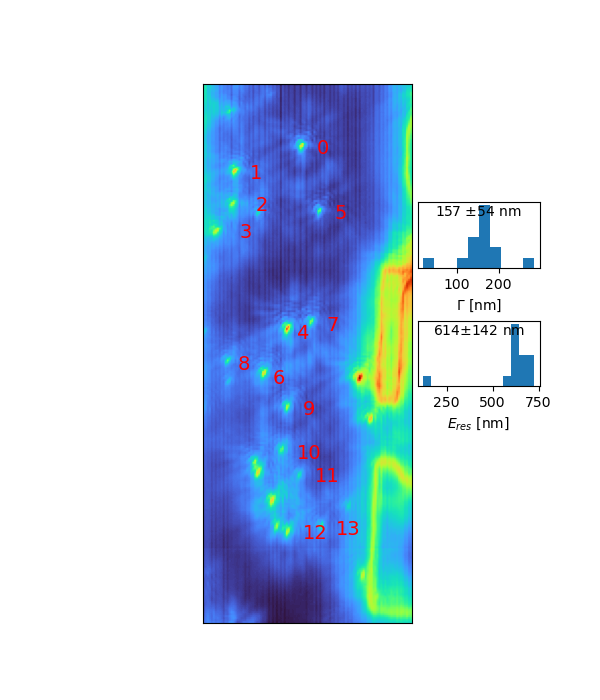

[201.2383316  179.07653931 284.66617194  20.70190687 161.24301237
 155.63883562 165.51384277 182.03927822 129.74446656 151.8181125
 152.81335727 154.50939962 139.54396572 114.06726912]
[591.45344288 605.72802387 676.52008509 121.57309905 726.92554422
 615.50027934 714.20968432 623.35516213 701.00801356 620.08664067
 661.42156358 658.54374897 638.52865078 634.81016003]


In [11]:
fig = plt.figure(figsize=[6,7])#constrained_layout=True)
gs = fig.add_gridspec(5,3)
ax1 = fig.add_subplot(gs[:,0:3])
ax2 = fig.add_subplot(gs[1, 2])
ax3 = fig.add_subplot(gs[2, 2])

for i in range(numPart):
#     ax1.add_patch(plt.Circle([int(positions[i][0]-1), int(positions[i][1]-1)], radius=5, edgecolor='r',lw=2, fill=False))        
    ax1.annotate(str(i), fontsize=14, xy=[int(positions[i][0]+5), int(positions[i][1]+5)],color='red')

print(gam_tot)
print(eres_tot)
ax1.imshow(np.sum(inten_raw,2).T, cmap='turbo')
ax1.set_xticks([]); ax1.set_yticks([])

labelgam= str(int(np.round(np.mean(gam_tot)))) + str(' $\pm$') + str(int(np.round(np.std(gam_tot)))) + str(' nm') 
ax2.hist(gam_tot, bins='auto', density=True)
ax2.set_title(labelgam, y=1, pad=-10, fontsize=10)
ax2.set_yticks([])

labeleres = str(int(np.round(np.mean(eres_tot)))) + str('$\pm$') + str(int(np.round(np.std(eres_tot)))) + str(' nm') 
ax3.hist(eres_tot,  bins='auto', density=True)
ax3.set_title(labeleres, y=1, pad=-10, fontsize=10)

ax3.set_yticks([])

ax2.set_xlabel('$\Gamma$ [nm]')
ax3.set_xlabel('$E_{res}$ [nm]')


fig.subplots_adjust(wspace=0.4, hspace=0.8)
# plt.savefig('demo.png', transparent=True)